In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from util import *
import figutil as fgu 
sns.set(font_scale=1)

In [2]:
df_scale = load_scale()[["prefix","run","iteration","size",
        "incremental.healthy","incremental.timeout","incremental.total[ms]","incremental.sync[ms]","incremental.prop[ms]",
        "problog.exitcode",   "problog.timeout",    "problog.total[ms]",
        "storm.healthy",      "storm.timeout",      "storm.total[ms]"
]]
df_scale['incremental.engine[ms]']=df_scale['incremental.total[ms]']-(df_scale['incremental.sync[ms]']+df_scale["incremental.prop[ms]"])
df_scale['incremental.total[s]'] = df_scale['incremental.total[ms]']/1000
df_scale['problog.total[s]'] = df_scale['problog.total[ms]']/1000
df_scale['storm.total[s]'] = df_scale['storm.total[ms]']/1000

sat_range = pd.DataFrame({'size':[20,40,60,80]})
sh_range = pd.DataFrame({'size':[100,200,300,400]})
srv_range = pd.DataFrame({'size':[10,100,1000,10000]})

PROPS = {
    'boxprops':{'facecolor':'seagreen', 'edgecolor':'black'},
#    'medianprops':{'color':'blue'},
#    'whiskerprops':{'color':'black'},
#    'capprops':{'color':'black'}
}
meanprops={
    'marker':'o',
    'markerfacecolor':'white', 
    'markeredgecolor':'black',
    'markersize':'6'
}

In [3]:
df =df_scale
domain = df[(df['prefix']=='SRV') & (df['size']==10000)] # Filter domain


count = domain.dropna(subset='incremental.timeout').groupby(['size']).count().reset_index()[['size','prefix']].rename(columns={'prefix':'count'}).astype({'count':'int'}).set_index(['size'])#.join(
domain[['storm.timeout', 'storm.healthy']]



,storm.timeout,storm.healthy
550,True,False
551,True,True
552,True,False
553,True,False
554,True,False
555,True,False
556,True,False
557,True,False
558,True,False
559,True,True


## Tool scaling

Reduced data for incremental on SAT.
   size        Mean
0    20    0.017976
1    40    0.091654
2    60    2.779043
3    80  105.160774
   size  count  timeouts  timeout %
0    20     50       0.0        0.0
1    40     50       0.0        0.0
2    60     50       0.0        0.0
3    80     50       0.0        0.0
Reduced data for incremental on SRV.
    size         Mean
0     10     0.021961
1    100     0.218383
2   1000    15.403274
3  10000  1039.293329
       size  count  timeouts  timeout %
0  2.302585     50       0.0        0.0
1  4.605170     50       0.0        0.0
2  6.907755     50       0.0        0.0
3  9.210340     50      20.0       40.0
Reduced data for incremental on SH.
   size        Mean
0   100    0.137005
1   200    1.157450
2   300  189.455851
3   400         NaN
   size  count  timeouts  timeout %
0   100     50       0.0        0.0
1   200     50       0.0        0.0
2   300     50       0.0        0.0
3   400     20      20.0      100.0
Reduced data for pro

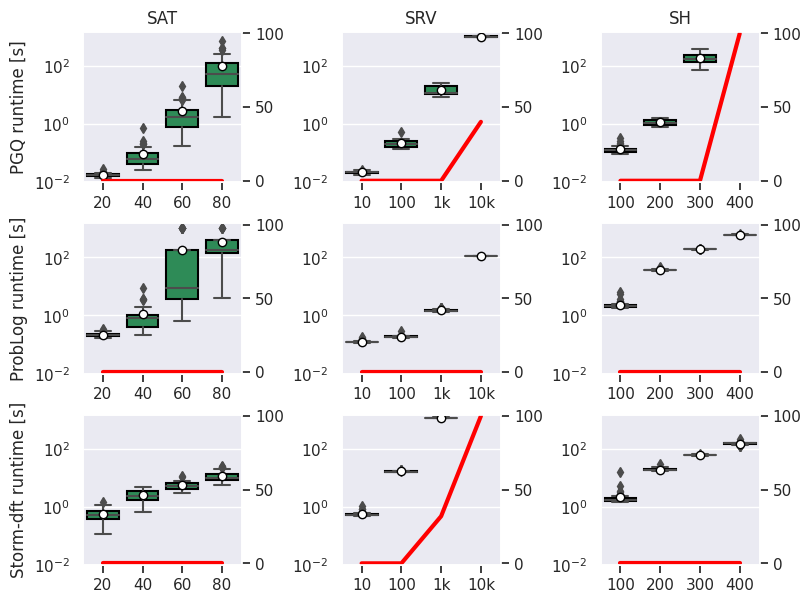

In [4]:
def subScaleChart(df, ax, case, tool, dfy_name, sizes, ylabel_left=None, ylabel_right=None, xlabel=None, title=None, legend=False, aux_log=False):
    domain = df[df['prefix']==case] # Filter domain

    # Base scale diagram
    completed = domain[validResult(domain, tool)] # Filter completed results
    all_completed = completed.set_index(['size']).join(sizes.set_index(['size']),how='outer').reset_index() # Fix x axis for missing data
    im = sns.boxplot(x='size', y=dfy_name, data=all_completed, ax=ax, showmeans=True, meanprops=meanprops, **PROPS)
    im.axes.set_yscale('log')
    ax.set(title=title, ylabel=ylabel_left, xlabel=xlabel)
    if case == 'SRV':
        ax.set_xticklabels(['10', '100', '1k', '10k'])
    im.axes.set_ylim(0.01, 1500)

    print("=========================================================================")
    print(f"Reduced data for {tool} on {case}.")
    print(all_completed.groupby(['size']).mean(numeric_only=True).reset_index()[['size',f"{tool}.total[s]"]].rename(columns={f"{tool}.total[s]": "Mean"}))
    
    # Compute timeout
    active = domain.dropna(subset=f'{tool}.timeout')
    count = active.groupby(['size']).count().reset_index()[['size','prefix']].rename(columns={'prefix':'count'}).astype({'count':'int'}).set_index(['size'])#.join(
    timeout = active[timeoutResult(active, tool)].groupby(['size']).count().reset_index()[['size','prefix']].rename(columns={'prefix':'timeouts'}).astype({'timeouts':'int'}).set_index(['size']),
    rate = count.join(timeout, how='outer').reset_index().fillna(0)
    rate['timeout %'] = rate['timeouts']/rate['count']*100

    # Timeout diagram
    if aux_log:
        rate['size'] = np.log(rate['size'])
    im = sns.lineplot(data=rate, x='size',y='timeout %', ax=ax.twiny().twinx(), color='red', legend=False, linewidth=3)
    im.axes.set_ylim(-1,101)
    im.axes.set_ylabel(None)
    
    # fix timeout axis for log measurements
    if aux_log:
        low = np.log(sizes['size'].min())
        high = np.log(sizes['size'].max())
        count = sizes['size'].count()-1
        step = (high-low)/(count)
        im.axes.set_xlim(low-(step/2),high+(step/2))
    else:
        low = sizes['size'].min()
        high = sizes['size'].max()
        count = sizes['size'].count()-1
        step = (high-low)/(count)
        im.axes.set_xlim(low-(step/2),high+(step/2))
    im.axes.grid(False)
    im.axes.set_xticks([])

    print(rate[['size','count','timeouts','timeout %']])



#fgu.sns_page()
#fgu.sns_col()
#fig, axes = plt.subplots(3, 3, **fgu.toSize(4,3,1.6))
fig, axes = plt.subplots(3, 3, figsize=(8,6), layout='constrained')
fig.suptitle(None)

subScaleChart(df_scale, axes[0,0], 'SAT', 'incremental', 'incremental.total[s]', sat_range, title='SAT', ylabel_left='PGQ runtime [s]')
subScaleChart(df_scale, axes[0,1], 'SRV', 'incremental', 'incremental.total[s]', srv_range, title='SRV', aux_log=True)
subScaleChart(df_scale, axes[0,2], 'SH', 'incremental', 'incremental.total[s]', sh_range, title='SH')

subScaleChart(df_scale, axes[1,0], 'SAT', 'problog', 'problog.total[s]', sat_range, ylabel_left='ProbLog runtime [s]')
subScaleChart(df_scale, axes[1,1], 'SRV', 'problog', 'problog.total[s]', srv_range, aux_log=True)
subScaleChart(df_scale, axes[1,2], 'SH', 'problog', 'problog.total[s]', sh_range)

subScaleChart(df_scale, axes[2,0], 'SAT', 'storm', 'storm.total[s]', sat_range, ylabel_left='Storm-dft runtime [s]')
subScaleChart(df_scale, axes[2,1], 'SRV', 'storm', 'storm.total[s]', srv_range, aux_log=True)
subScaleChart(df_scale, axes[2,2], 'SH', 'storm', 'storm.total[s]', sh_range)

fig.savefig("figures/scaling.pdf", bbox_inches='tight')

## Relative PGQ component scaling

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_10947/1852935417.py:2: SyntaxWarning: invalid escape sequence '\.'
  data = data.filter(regex=(f'prefix|size|incremental\..*')).groupby(['prefix', 'size']).aggregate('mean').reset_index()
/tmp/ipykernel_10947/1852935417.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.filter(regex=(f'prefix|size|incremental\..*')).groupby(['prefix', 'size']).aggregate('mean').reset_index()


PGQ mean times
   prefix   size       QPT%       EPT%      SYNC%
0     SAT     20  73.323756  13.501498  13.174746
1     SAT     40  20.626875  76.422231   2.950894
2     SAT     60   1.970490  97.677417   0.352093
3     SAT     80   0.147666  99.813795   0.038538
4      SH    100  88.416801   8.239355   3.343844
5      SH    200  43.079224  55.456849   1.463927
6      SH    300   0.573743  99.383276   0.042981
7     SRV     10  76.868304  11.025207  12.106489
8     SRV    100  83.226478  13.517762   3.255760
9     SRV   1000  77.339414  18.433128   4.227457
10    SRV  10000  63.887964  31.901233   4.210803


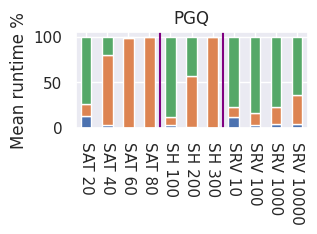

In [8]:
data = df_scale[validResult(df_scale, 'incremental')]
data = data.filter(regex=(f'prefix|size|incremental\..*')).groupby(['prefix', 'size']).aggregate('mean').reset_index()
data['x'] = data['prefix']+" "+data['size'].astype(str)

data['Total time'] = data['incremental.engine[ms]'] + data['incremental.sync[ms]'] + data['incremental.prop[ms]']
data['QPT%'] = data['incremental.engine[ms]'] / data['Total time'] * 100
data['EPT%'] = data['incremental.prop[ms]'] / data['Total time'] * 100
data['SYNC%'] = data['incremental.sync[ms]'] / data['Total time'] * 100

fig, ax = plt.subplots(1, 1, figsize=oneCol(12,5))
fig.suptitle('')

data = data.rename({"SRV 1000":"SRV 1k", "SRV 10000": "SRV 10k"})

data.plot(kind='bar',ax=ax, x='x',y=['SYNC%','EPT%','QPT%'],stacked=True,legend=False)
ax.tick_params(axis='x', labelrotation=-90)
ax.set(title='PGQ', ylabel='Mean runtime %', xlabel=None)
#axes[0].get_legend().set_visible(False)
ax.axvline(3.5,0,1,color='purple')
ax.axvline(6.5,0,1,color='purple')
print('PGQ mean times')
print(data[['prefix','size','QPT%','EPT%','SYNC%']])

fig.savefig("figures/scale-reative.pdf", bbox_inches='tight')

# Legacy code (ignore)

In [6]:
#range = pd.DataFrame({'size':[10,100,1000,10000]})
def filter_completed(df, kind):
    tmp = df[df[f'{kind}.timeout']==False].filter(regex=(f'prefix|size|{kind}\..*')).groupby(['prefix', 'size']).aggregate('mean').reset_index()
    tmp['x'] = tmp['prefix']+" "+tmp['size'].astype(str)

    return tmp


#df_pgq_ok = df[df['incremental.timeout']==False].filter(regex=('prefix|size|incremental\..*')).groupby(['prefix', 'size']).aggregate('mean').reset_index()
#df_pgq_ok['x'] = df_pgq_ok['prefix']+" "+df_pgq_ok['size'].astype(str)

#df_pl_ok = df[df['problog.timeout']==False].filter(regex=('prefix|size|problog\..*')).groupby(['prefix', 'size']).aggregate('mean').reset_index()
#df_pl_ok['x'] = df_pl_ok['prefix']+" "+df_pl_ok['size'].astype(str)

df_pgq_ok = filter_completed(df, "incremental")
df_pgq_ok['TT'] = df_pgq_ok['incremental.engine[ms]'] + df_pgq_ok['incremental.sync[ms]'] + df_pgq_ok['incremental.prop[ms]']
df_pgq_ok['QPT%'] = df_pgq_ok['incremental.engine[ms]'] / df_pgq_ok['TT'] * 100
df_pgq_ok['EPT%'] = df_pgq_ok['incremental.prop[ms]'] / df_pgq_ok['TT'] * 100
df_pgq_ok['SYNC%'] = df_pgq_ok['incremental.sync[ms]'] / df_pgq_ok['TT'] * 100


df_pl_ok = filter_completed(df, "problog")
df_pl_ok['TT'] = df_pl_ok['problog.trafo[ms]'] + df_pl_ok['problog.evaluation[ms]']
df_pl_ok['Transformation %'] = df_pl_ok['problog.trafo[ms]'] / df_pl_ok['TT'] * 100
df_pl_ok['Analysis %'] = df_pl_ok['problog.evaluation[ms]'] / df_pl_ok['TT'] * 100

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_10947/1648609684.py:3: SyntaxWarning: invalid escape sequence '\.'
  tmp = df[df[f'{kind}.timeout']==False].filter(regex=(f'prefix|size|{kind}\..*')).groupby(['prefix', 'size']).aggregate('mean').reset_index()
/tmp/ipykernel_10947/1648609684.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df[df[f'{kind}.timeout']==False].filter(regex=(f'prefix|size|{kind}\..*')).groupby(['prefix', 'size']).aggregate('mean').reset_index()
/tmp/ipykernel_10947/1648609684.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid 

KeyError: 'problog.trafo[ms]'

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9,6))
fig.suptitle('')

df_pgq_ok.plot(kind='bar',ax=ax, x='x',y=['SYNC%','EPT%','QPT%'],stacked=True,legend=False)
ax.tick_params(axis='x', labelrotation=-90)
ax.set(title='PGQ', ylabel='Mean runtime %', xlabel=None)
#axes[0].get_legend().set_visible(False)
ax.axvline(3.5,0,1,color='purple')
ax.axvline(6.5,0,1,color='purple')
print('PGQ mean times')
print(df_pgq_ok)

fig.savefig("figures/scale-reative.pdf", bbox_inches='tight')

In [ ]:

df_case=df


range = pd.DataFrame({'size':[20,40,60,80,100,200,300,400,10,100,1000,10000]})

df_case_inc_ok = df_case[df_case['incremental.timeout']==False].set_index(['size']).join(range.set_index(['size']),how='outer').reset_index()
df_case_pl_ok = df_case[df_case['problog.timeout']==False].set_index(['size']).join(range.set_index(['size']),how='outer').reset_index()

df_mean = df_case.groupby(['prefix','size']).mean().reset_index()[['prefix','size','incremental.total[ms]','problog.total[ms]']]
df_mean['incremental.total[ms]'] = df_mean['incremental.total[ms]'].apply(lambda x : '{:_.2f}'.format(x))
print(df_mean)
